In [120]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
import shutil
import os
import glob
import math
import tarfile
import requests
import json

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

from log_analysis import *
from os import listdir
from os.path import isfile, join


In [121]:
model_name = "first-gblasd"
is_training =  False # Make this False if you want to do log analysis on Evaluation

In [122]:
!ls

Analysis.ipynb     __pycache__        log_analysis.py
Evaluation         cw_utils.py        markdown_helper.py
Training           data               tracks


In [123]:
with open("data/model_metadata.json","r") as jsonin:
    model_metadata=json.load(jsonin)
sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
model_metadata

{'action_space': {'steering_angle': {'high': 30.0, 'low': -30.0},
  'speed': {'high': 1.0, 'low': 0.5}},
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'version': '4',
 'training_algorithm': 'clipped_ppo',
 'action_space_type': 'continuous'}

In [124]:
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
print(ListFiles)

['reInvent2019_track.npy', 'Aragon.npy', '2022_june_pro_cw.npy', 'caecer_loop.npy', 'jyllandsringen_open.npy', 'hamption_pro.npy', '2022_september_open_ccw.npy', 'Monaco_building.npy', '2022_july_pro_ccw.npy', 'reInvent2019_wide_ccw.npy', 'arctic_pro_cw.npy', 'Canada_Training.npy', 'reInvent2019_wide.npy', 'dubai_open_ccw.npy', 'thunder_hill_pro.npy', '2022_april_open_cw.npy', 'Tokyo_Training_track.npy', '2022_august_open_cw.npy', '2022_summit_speedway_ccw.npy', 'Oval_track.npy', 'thunder_hill_pro_cw.npy', '2022_june_open_ccw.npy', '2022_april_pro_cw.npy', '2022_october_open_cw.npy', 'reInvent2019_wide_mirrored.npy', '2022_reinvent_champ.npy', 'reInvent2019_track_cw.npy', 'AmericasGeneratedInclStart.npy', 'jyllandsringen_pro.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'Belille.npy', 'Austin.npy', 'H_track.npy', '2022_october_pro_ccw.npy', '2022_april_open_ccw.npy', '2022_august_pro_ccw.npy', 'Singapore.npy', 'reinvent_base.npy', '2022_april_pro_ccw.npy', '2022_october_pro_cw.npy', 

In [125]:
trackname='reInvent2019_wide'
waypoints = get_track_waypoints(trackname)
waypoints.shape

(112, 6)

In [126]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i, p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

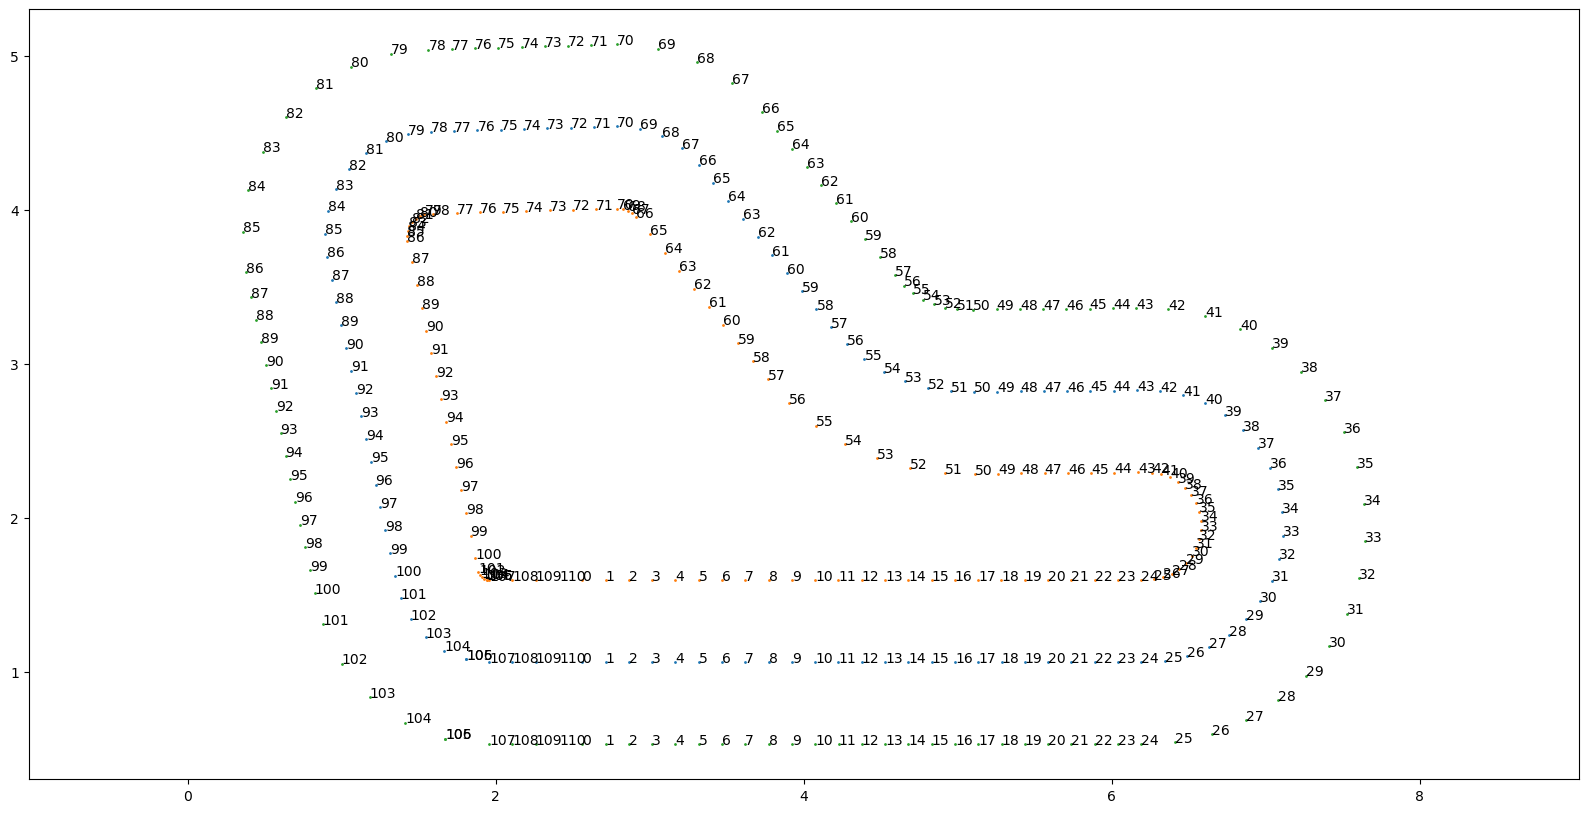

In [127]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

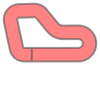

In [128]:
# Use Shapely to generate lines for the inner 
# and outer track borders, and centerline
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])

# Create a shapely Polygon representing the track
road_poly = Polygon(np.vstack((l_outer_border.coords, np.flipud(l_inner_border.coords))))
road_poly

In [129]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [130]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
    #   plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    #fig = plt.figure(1, figsize=(12, 16))
    fig = plt.figure(1, figsize=track_size)
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [131]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

In [132]:
EPISODE_PER_ITER = 20 if is_training else 1

In [133]:
merged_simtrace_path="Evaluation/6ea65861-7778-4ee4-88dc-fe7f71df2d44/sim-trace/evaluation/20240526202546-YbiA3g8nSIKkdNycxFO5lQ/evaluation-simtrace/0-iteration.csv"

df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/EPISODE_PER_ITER)+1) * EPISODE_PER_ITER
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,iteration
0,0,1.0,3.199881,0.683104,0.183214,-14.781045,0.705840,[-14.781045019626617 0.7058396860957146],0.0,False,True,0.791390,1,17.709159,5.144,prepare,0.0,1
1,0,2.0,3.199733,0.683103,0.183266,-14.669196,0.706949,[-14.669196009635925 0.7069494836032391],1.0,False,True,0.790551,1,17.709159,5.211,in_progress,0.0,1
2,0,3.0,3.211342,0.681845,-0.141130,-13.186312,0.726235,[-13.186311721801758 0.7262349221855402],1.0,False,True,0.856093,1,17.709159,5.280,in_progress,0.0,1
3,0,4.0,3.233842,0.676807,-1.382537,-8.683378,0.775890,[-8.683378100395203 0.7758897040039301],1.0,False,True,0.983106,1,17.709159,5.351,in_progress,0.0,1
4,0,5.0,3.267967,0.671403,-2.464919,4.163905,0.797345,[4.163905084133148 0.797345120459795],1.0,False,True,1.175755,1,17.709159,5.413,in_progress,0.0,1


In [134]:
NUM_ANGLE_BUCKETS = 5
NUM_SPEED_BUCKETS = 4

if 'action_space_type' in model_metadata and model_metadata['action_space_type']=='continuous':
    max_angle = model_metadata['action_space']['steering_angle']['high']
    min_angle = model_metadata['action_space']['steering_angle']['low']

    max_speed = model_metadata['action_space']['speed']['high']
    min_speed = model_metadata['action_space']['speed']['low']

    #Determine which discrete bucket would be the equivalent for the continuous action space
    for index, row in df.iterrows():        
        angle_bucket = math.floor(((row["steer"] - min_angle)/(max_angle-min_angle))*NUM_ANGLE_BUCKETS)
        speed_bucket = math.floor(((row["throttle"] - min_speed)/(max_speed-min_speed))*NUM_SPEED_BUCKETS)
        if angle_bucket==NUM_ANGLE_BUCKETS:
            angle_bucket -= 1
        if speed_bucket==NUM_SPEED_BUCKETS:
            speed_bucket -= 1
        df.at[index,"action"] = int(angle_bucket*NUM_SPEED_BUCKETS+speed_bucket)
    

    #Convert the model metadata in memory to use the new forced discrete action space
    angle_bucket_size = (max_angle-min_angle)/NUM_ANGLE_BUCKETS
    angle = min_angle+.5*angle_bucket_size
    speed_bucket_size = (max_speed-min_speed)/NUM_SPEED_BUCKETS
    speed = min_speed+.5*speed_bucket_size    
    model_metadata['action_space'] = []
    index = 0
    for anglei in range(0,NUM_ANGLE_BUCKETS):
        for speedi in range(0,NUM_SPEED_BUCKETS):
            model_metadata['action_space'].append({'index':index,
                                 'speed': speed,
                                 'steering_angle': angle})
            index+=1
            speed += speed_bucket_size
        angle += angle_bucket_size
        speed = min_speed+.5*speed_bucket_size
            
    print(df.head())

   episode  steps         x         y       yaw      steer  throttle action  \
0        0    1.0  3.199881  0.683104  0.183214 -14.781045  0.705840      5   
1        0    2.0  3.199733  0.683103  0.183266 -14.669196  0.706949      5   
2        0    3.0  3.211342  0.681845 -0.141130 -13.186312  0.726235      5   
3        0    4.0  3.233842  0.676807 -1.382537  -8.683378  0.775890      6   
4        0    5.0  3.267967  0.671403 -2.464919   4.163905  0.797345     10   

   reward   done  all_wheels_on_track  progress  closest_waypoint  track_len  \
0     0.0  False                 True  0.791390                 1  17.709159   
1     1.0  False                 True  0.790551                 1  17.709159   
2     1.0  False                 True  0.856093                 1  17.709159   
3     1.0  False                 True  0.983106                 1  17.709159   
4     1.0  False                 True  1.175755                 1  17.709159   

   timestamp episode_status  pause_duration 

In [135]:
df['y'].min(), df['x'].max()

(0.6093352980699515, 7.07401883254456)

In [136]:
df['reward'].min(), df['reward'].max()
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [137]:
df['reward'].min(), df['reward'].max()

(0.0, 1.0)

Number of episodes =  2


Text(0.5, 0, 'Episode')

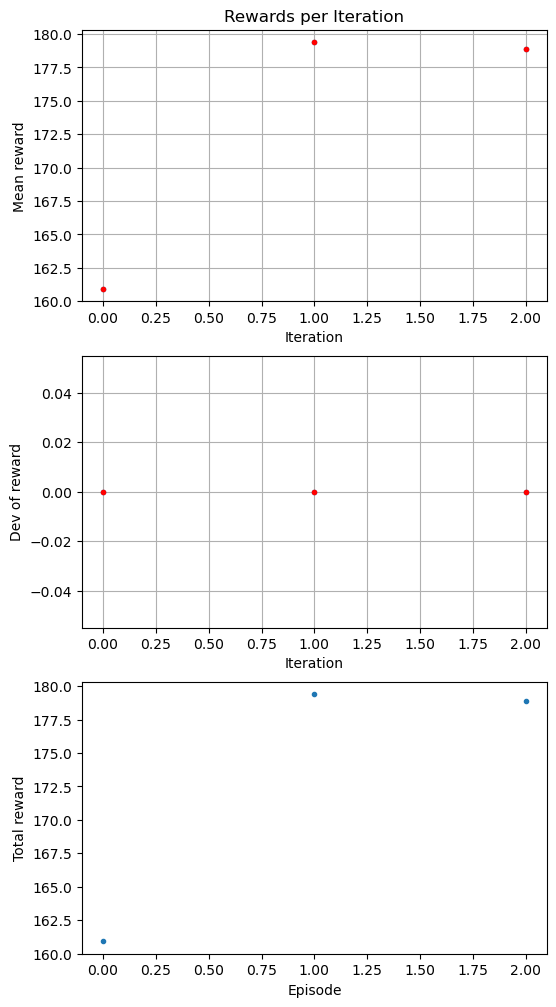

In [138]:
REWARD_THRESHOLD = 0

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
    
for epi in np.arange(min_episodes, max_episodes+1,1):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODE_PER_ITER:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

In [139]:
if is_training:
    METRIC_PATH = glob.glob("Training/metrics/training/*.json")[0]
else:
    METRIC_PATH = glob.glob("Evaluation/6ea65861-7778-4ee4-88dc-fe7f71df2d44/metrics/evaluation/*.json")[0]
    
with open(METRIC_PATH, "r") as fp:
    data = json.loads(fp.read())
    metric_data = data['metrics']
    df_metrics = pd.DataFrame(metric_data)

if is_training:
    df_metrics = df_metrics[df_metrics['phase'] == "training"]

In [140]:
df_metrics

,completion_percentage,metric_time,start_time,elapsed_time_in_milliseconds,episode_status,crash_count,immobilized_count,off_track_count,reversed_count,reset_count,trial
0,100,25547,5089,20458,Lap complete,0,0,0,0,0,1
1,100,46022,25615,20407,Lap complete,0,0,0,0,0,2
2,100,66750,46082,20668,Lap complete,0,0,0,0,0,3


Mean percentage: 100.0


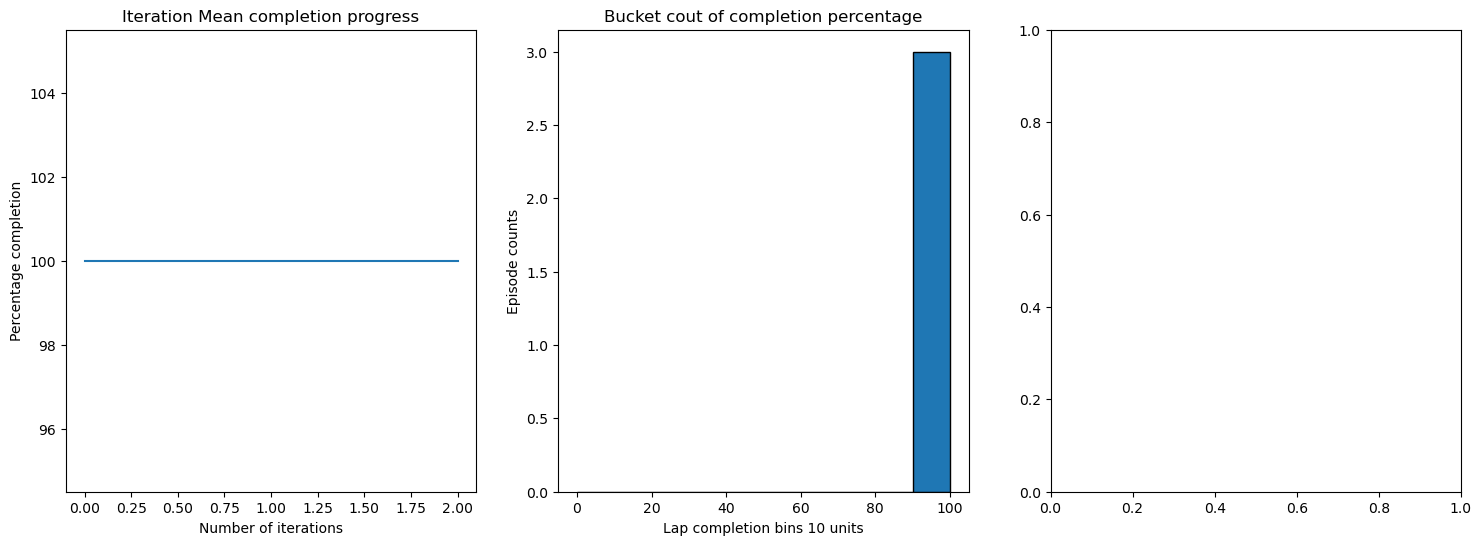

In [141]:
bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

df_metrics = df_metrics.sort_values(by="metric_time")
print('Mean percentage: {}'.format(df_metrics.completion_percentage.mean()))

completion_percentage_np = np.array(df_metrics.completion_percentage)
episode_progress_buckets = np.split(completion_percentage_np[:EPISODE_PER_ITER*(len(completion_percentage_np)//EPISODE_PER_ITER)],
                                    len(completion_percentage_np)//EPISODE_PER_ITER)
episode_progress_mean = np.mean(episode_progress_buckets, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Line graph showing the mean iteration of completion progress
ax1.plot(episode_progress_mean)
ax1.title.set_text('Iteration Mean completion progress')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Percentage completion')

# Bar chart to show completion_percentage with bucketing of 10% bar chart
ax2.hist(df_metrics.completion_percentage, bins=bins, edgecolor="k")
ax2.title.set_text('Bucket cout of completion percentage')
ax2.set_xlabel('Lap completion bins 10 units')
ax2.set_ylabel('Episode counts')

# Line graph showing the mean iteration of reward mean
if is_training:
    reward_score_np = np.array(df_metrics.reward_score)
    episode_reward_buckets = np.split(reward_score_np[:EPISODE_PER_ITER*(len(reward_score_np)//EPISODE_PER_ITER)],
                                                      len(reward_score_np)//EPISODE_PER_ITER)
    episode_reward_mean = np.mean(episode_reward_buckets, axis=1)
    ax3.plot(episode_reward_mean)
    plt.title("Metric analysis - Reward/percentage vs number of iterations")
    ax3.title.set_text('Iteration Mean reward')
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Reward score')
    plt.show()

In [142]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis 0.8661105280320246; Max x-axis 7.07401883254456
Min y-axis 0.6093352980699515; Max y-axis 4.387793192602723


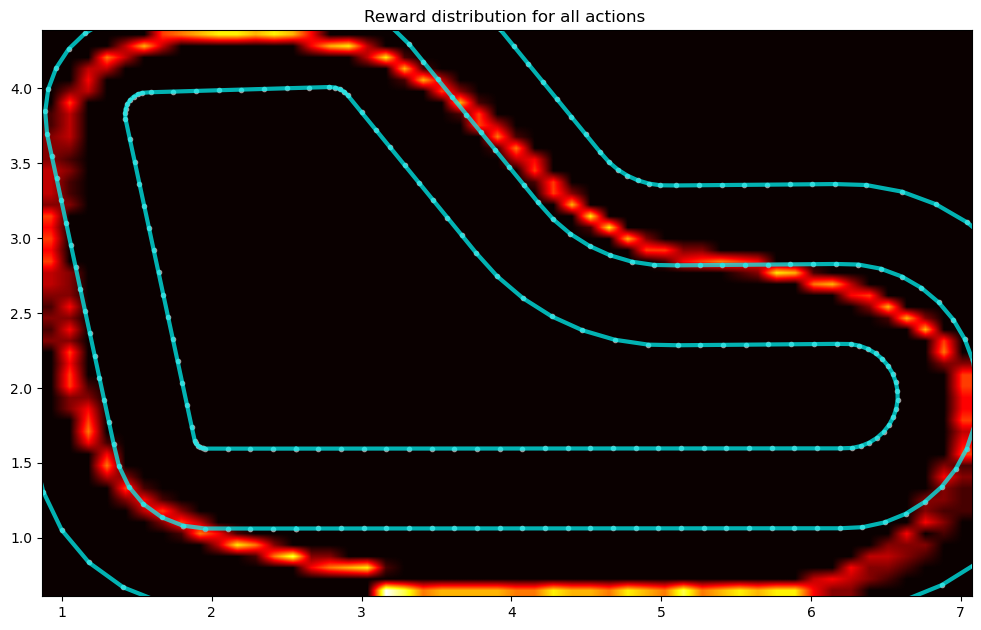

In [143]:
track, extent = plot_track(df, track_size=(12, 12), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

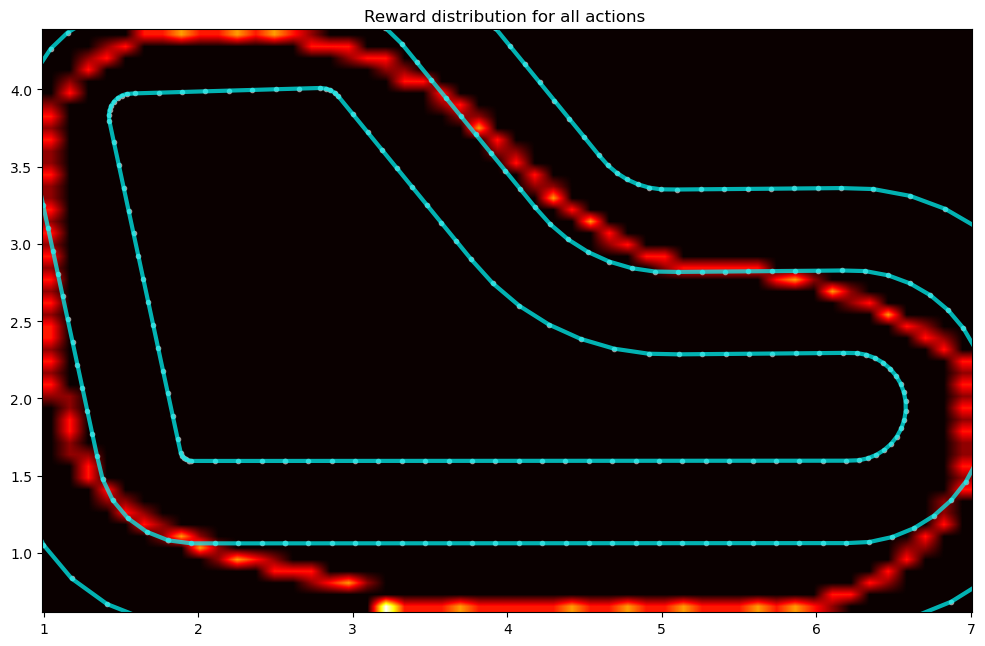

In [144]:
iteration_id = 1
track,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(12, 12), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

The top 3 highest reward episodes are [1, 2, 0]


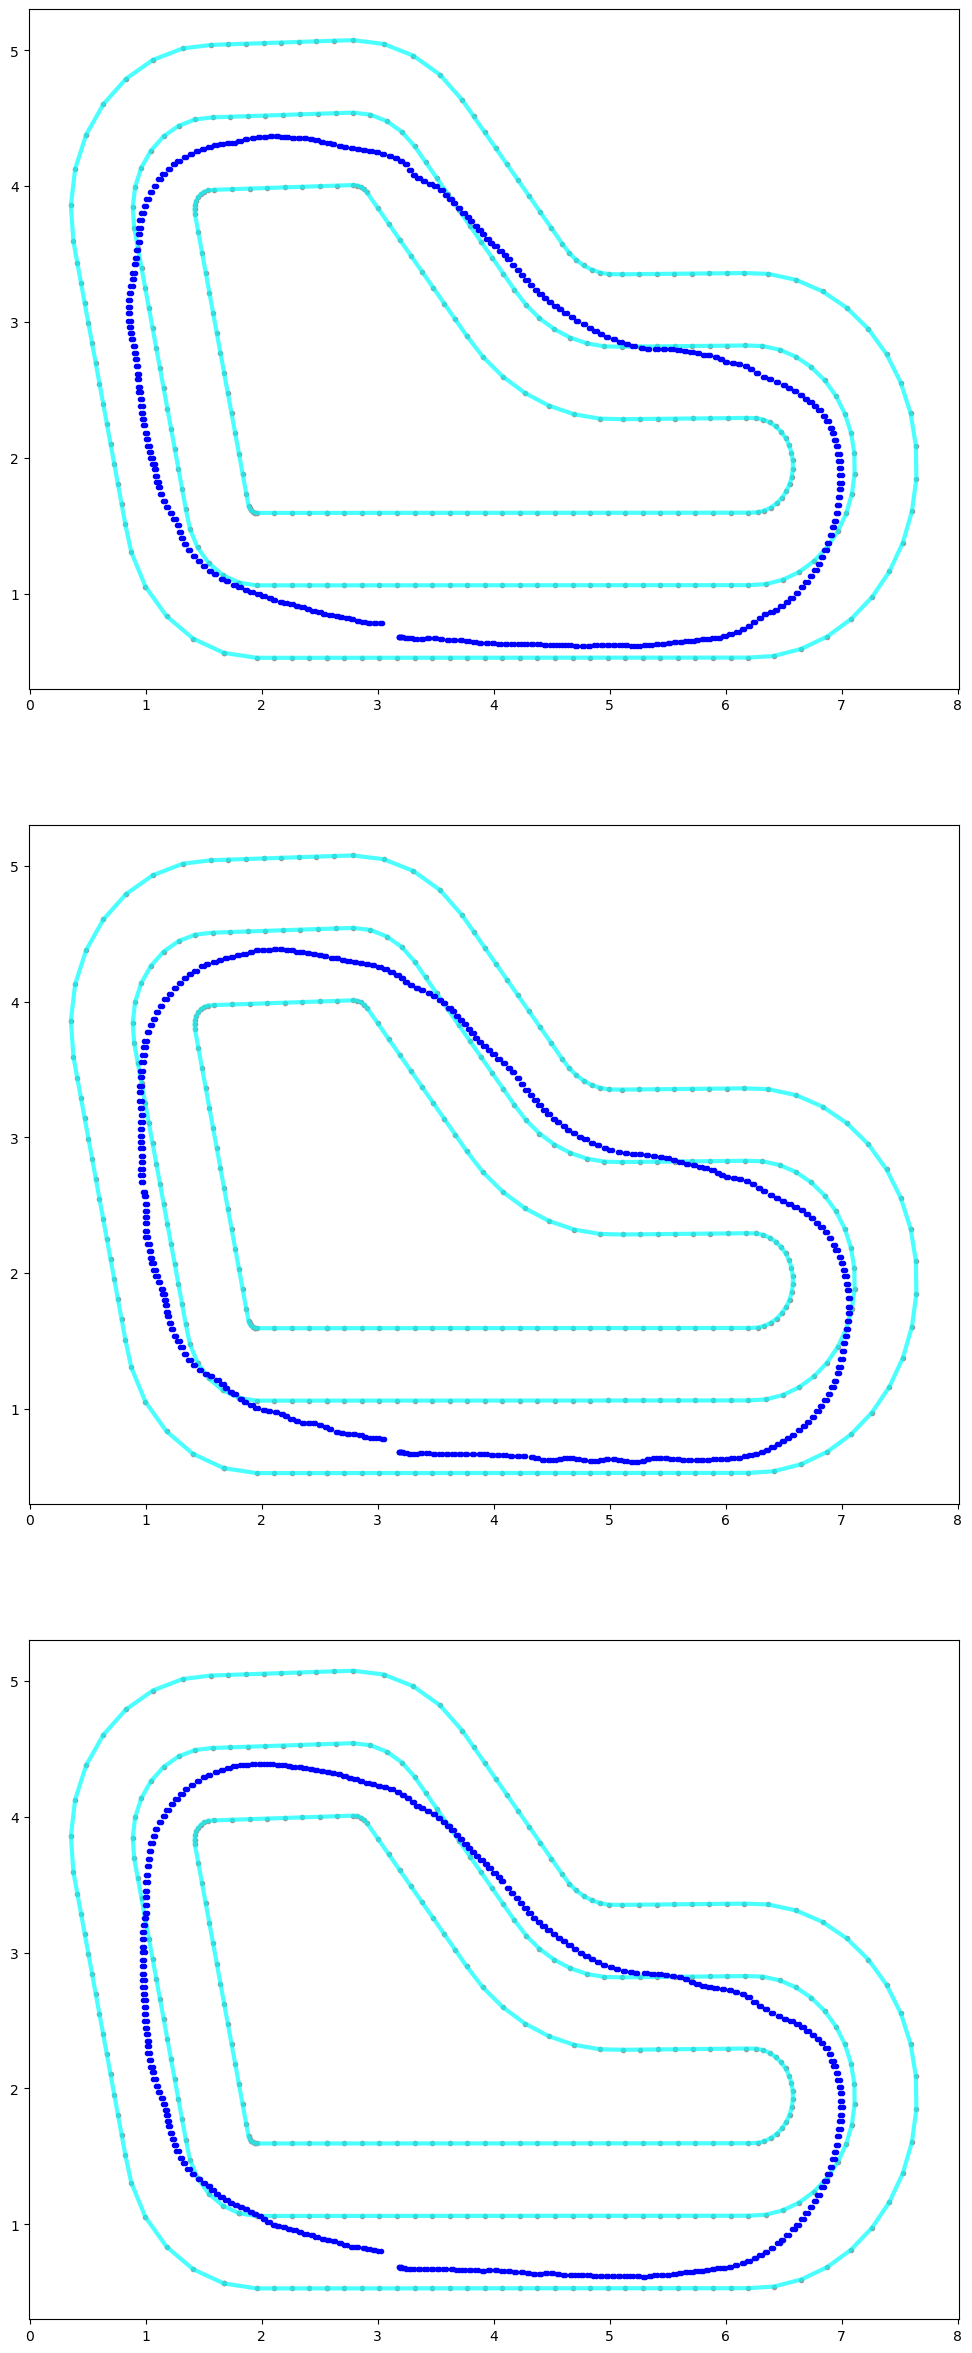

In [145]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

In [146]:
# The actions plotted on the tracks may become noise. Use this to clip the low reward values action.
# Anything with reward < 0.8 is clipped. This is based on the reward function you trained on.

REWARD_THRESHOLD = 0.8

In [147]:
# Track Segment Labels
action_names = []
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])
action_names

['ST-24.0 SP0.56',
 'ST-24.0 SP0.69',
 'ST-24.0 SP0.81',
 'ST-24.0 SP0.94',
 'ST-12.0 SP0.56',
 'ST-12.0 SP0.69',
 'ST-12.0 SP0.81',
 'ST-12.0 SP0.94',
 'ST0.0 SP0.56',
 'ST0.0 SP0.69',
 'ST0.0 SP0.81',
 'ST0.0 SP0.94',
 'ST12.0 SP0.56',
 'ST12.0 SP0.69',
 'ST12.0 SP0.81',
 'ST12.0 SP0.94',
 'ST24.0 SP0.56',
 'ST24.0 SP0.69',
 'ST24.0 SP0.81',
 'ST24.0 SP0.94']

In [150]:
track_segments_hash = { "reinvent_base": [(0, 'straightaway'),
                                          (20, 'hairpin'),
                                          (46, 'slight right'),
                                          (61, 'left'),
                                          (76, 'slight left'),
                                          (90, 'straightaway'),
                                          (103, 'left'),
                                          (111, 'straightaway')                                         
                                          ],
                       "reInvent2019_track": [(0, 'left'),
                                              (18, 'sharp right'),
                                              (33, 'gentle left'),
                                              (82, 'left'),
                                              (93, 'slight left'),
                                              (107, 'left'),
                                              (117, 'right'),
                                              (137, 'left')
                                             ],
                       "arctic_open": [(0, 'straightaway'),
                                       (24,'left'),
                                       (36,'right'),
                                       (52,'left'),
                                       (67,'hairpin left'),
                                       (84,'right'),
                                       (98,'slight left'),
                                       (107,'straightaway'),
                                       (125,'slight left'),
                                       (134,'straightaway'),
                                       (156,'hairpin left')            
                       ],
                       "caecer_loop": [(0, 'straightaway'),
                                       (14,'slight left'),
                                       (34,'straightaway'),
                                       (42,'hairpin left'),
                                       (70,'straightaway'),
                                       (80,'sharp left'),
                                       (93,'straightaway'),
                                       (103,'slight left'),
                                       (115,'straightaway')            
                       ],
                       "red_star_open":[(0,'straightaway'),
                                        (29,'left'),
                                        (41,'straightaway'),
                                        (67,'hairpin left'),
                                        (78,'straightaway'),
                                        (94,'s-turn right'),
                                        (107,'s-turn left'),
                                        (119,'s-turn right'),
                                        (130,'s-turn left'),
                                        (140,'straightaway'),
                                        (155,'sharp left'),
                                        (163,'straightaway')                           
                       ]
}
trackname

trackname = "reinvent_base"

This hash defines the labels for track segments on various tracks. Analyzing new tracks will require adding a new entry to this hash.

Number of steps in iteration= 307


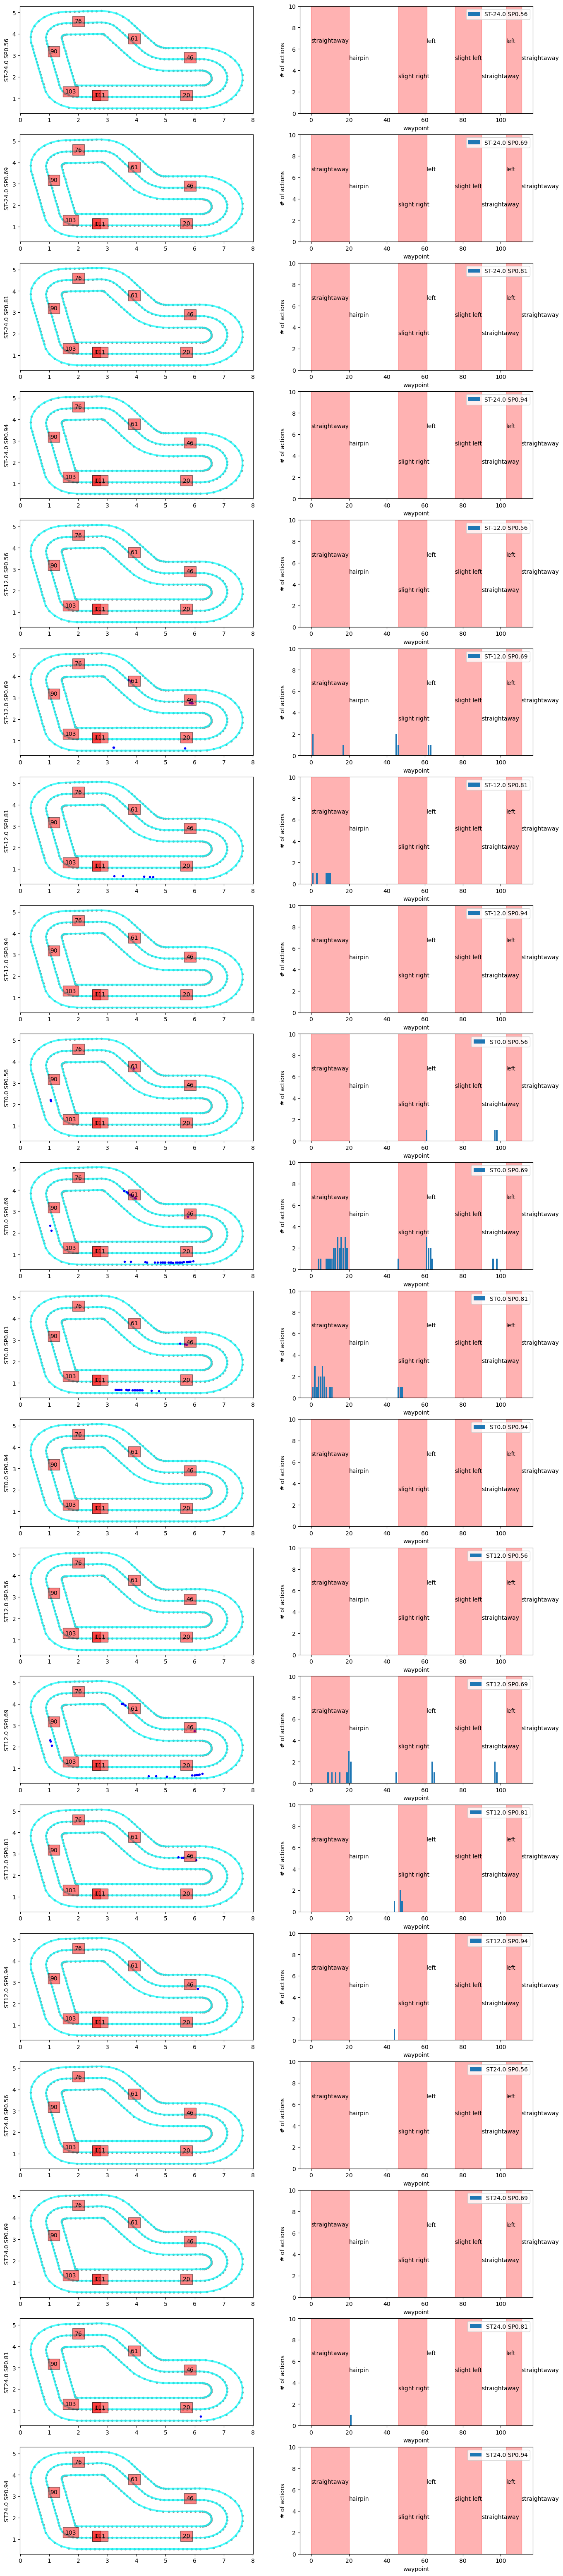

In [151]:
fig = plt.figure(figsize=(16, 4*len(action_names)))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

y_limit = 10
track_segments = track_segments_hash[trackname]
segment_x=[]
segment_y=[]
segment_xerr_l=[]
segment_xerr_r=[]
segment_yerr_n=[]
segment_yerr_s=[]
i=0
while i<len(track_segments):
    segment_x.append(track_segments[i][0])
    segment_y.append(0)
    segment_xerr_l.append(0)
    if i>=len(track_segments)-1:
        segment_xerr_r.append(len(waypoints)-track_segments[i][0])
    else:
        segment_xerr_r.append(track_segments[i+1][0]-track_segments[i][0])
    segment_yerr_n.append(0)
    segment_yerr_s.append(y_limit)
    i+=2

segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_xerr = np.array([segment_xerr_l,segment_xerr_r])
segment_yerr = np.array([segment_yerr_n,segment_yerr_s])

#segment_x = np.array(vert_lines)
#segment_y = np.array([0]*len(vert_lines))
#segment_xerr = np.array([[0]*len(vert_lines),[1]*len(vert_lines)])
#segment_yerr = np.array([[0]*len(vert_lines), [150]*len(vert_lines)])

wpts_array = center_line 
text_y=[.66*y_limit,.5*y_limit,.33*y_limit]
    
for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    # Reward function threshold
    th = REWARD_THRESHOLD
    for idx in range(len(action_names)):
        ax = fig.add_subplot(len(action_names), 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in track_segments:
            ax.text(wpts_array[idWp[0]][0], wpts_array[idWp[0]][1], str(idWp[0]), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(len(action_names), 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)


        i=0
        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], text_y[i], track_segments[tt][1])
            i = (i+1)%len(text_y)

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, y_limit))

In [116]:
len(center_line)

112